In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import csv
data = []
with open("cleaned/NY.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        data.append(int(i[5]))

train  = data[:-300]
test = data[-300:]

li_x = []
li_y = []
seq = 2

# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[:-300]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

t_x = []
t_y = []
# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[-300:]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据*
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

# print(li_x)
# print(li_y)

# 分训练和测试集
train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)

print(train_x.shape)

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

torch.Size([408, 2, 1])


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [5]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fun = nn.MSELoss()

In [6]:
model.train()
list_l = []
list_tl = []
for epoch in range(1200):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        list_l.append(loss)
        list_tl.append(test_loss)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))

epoch:20, loss:6.515935897827148, test_loss: 17.937255859375
epoch:40, loss:2.050569534301758, test_loss: 11.095090866088867
epoch:60, loss:0.8987833857536316, test_loss: 9.307195663452148
epoch:80, loss:0.6634519696235657, test_loss: 8.535491943359375
epoch:100, loss:0.5544741153717041, test_loss: 8.176715850830078
epoch:120, loss:0.4820620119571686, test_loss: 7.94504976272583
epoch:140, loss:0.4328151047229767, test_loss: 7.779496669769287
epoch:160, loss:0.4020805358886719, test_loss: 7.6627278327941895
epoch:180, loss:0.3868686854839325, test_loss: 7.585817813873291
epoch:200, loss:0.3803873360157013, test_loss: 7.533310413360596
epoch:220, loss:0.37774327397346497, test_loss: 7.493923664093018
epoch:240, loss:0.37659740447998047, test_loss: 7.461578369140625
epoch:260, loss:0.37593525648117065, test_loss: 7.435798645019531
epoch:280, loss:0.37547022104263306, test_loss: 7.4147467613220215
epoch:300, loss:0.37508782744407654, test_loss: 7.398769378662109
epoch:320, loss:0.37473437

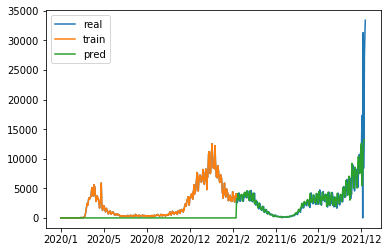

In [7]:
model.eval()
# result = li_x[0][:seq-1] + list((model(train_x).data.reshape(-1))*1000) + list((model(test_x).data.reshape(-1))*1000)
result = [0] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)
#展示结果
plt.plot(data,label="real")
# 原来的走势

plt.plot(train,label="train")

plt.plot(result,label="pred")
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '20211/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')
plt.savefig('plot/NY_Epoch1200.jpg')

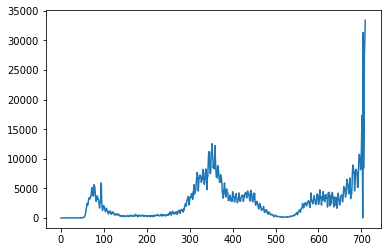

In [8]:
plt.plot(data)

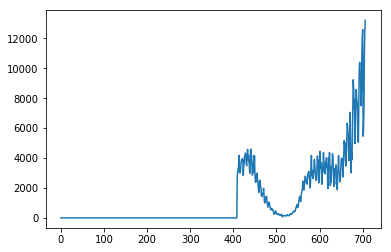

In [9]:
plt.plot(result)

In [10]:
# unpredictive
# 

In [15]:
print(list_l[0][0])

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number